# Analyzing Hotels reviews using sophisticated sentiment analysis

## Imports

In [1]:
!pip install langdetect

In [2]:
import requests
from langdetect import detect
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### API keys
Note that we use two APIs throughout this notebook, hence two different keys are required. How you can get them?

**RapidAPI key**: create a free account at [RapidAPI](https://rapidapi.com/hub).

**AI21 Studio**: create a free account at [AI21 Studio](https://studio.ai21.com). You can see you API key in the *Account* tab.

In [3]:
RAPID_API_KEY = ""
AI21Studio_API_KEY = ""

## Connect to Hotels API and collect reviews

In [4]:
GET_REVIEWS_URL = "https://hotels-com-provider.p.rapidapi.com/v1/hotels/reviews"

def get_hotel_reviews_page(hotel_id, page_number):
    params = {
        "locale": "en_US", 
        "hotel_id": hotel_id, 
        "page_number": str(page_number)
    }
    headers = {
        "X-RapidAPI-Key": RAPID_API_KEY,
        "X-RapidAPI-Host": "hotels-com-provider.p.rapidapi.com"
    }
    response = requests.get(url=GET_REVIEWS_URL, headers=headers, params=params)
     
    reviews = [
        review['summary'] 
        for page_reviews in response.json()['groupReview']
        for review in page_reviews['reviews']
    ]
    return reviews


def get_hotel_reviews(hotel_id, num_pages):
    all_reviews = sum(
        [get_hotel_reviews_page(hotel_id, page_number) for page_number in range(1, num_pages + 1)],
        start=[]
    )
    return all_reviews

In [5]:
# This is the hotel: https://www.hotels.com/ho125729/?locale=en_IL&pos=HCOM_IL&siteid=300000016

reviews = get_hotel_reviews(hotel_id=125729, num_pages=8)

In [6]:
print(len(reviews))

400


## Pre-Process the reviews

Filter reviews which are too short or not in English

In [7]:
def print_list(lis):
    for item in lis:
        print(item)
        print("===========================")

In [8]:
# Look at them
print_list(reviews[:30])

Service was quite bad.  
Quiet- great location 
Very affordable (at least for NYC) and great location. Rooms were a bit small but clean and comfortable. 
- View was terrible for a $500 room - the back of the other wing, at least we could hear the empty beer bottles being thrown out during the night
- No top sheet on the bed ,just bottom & comforter
- Bathroom tile was loose
- 1/2 empty coke bottle in fridge
- No Coffee or even a continental breakfast, granola bars or a piece of fruit included
- Pool & pool deck is closed
- Rooftop bar is not affiliated with hotel 
- towels are dumped in the lobby if you want more, classy
- Corridors are too dark
Bathroom is sized and looks like it came from an RV 



Excellent place to stay especially if you have tickets to events at Lincoln Center.
I have stayed here before and had no problem but this time when I checked in I was given a room with a full size bed when my reservation was for a qn. When I notified the hotel they told me that the the roo

In [9]:
def filter_reviews(reviews):
    en_reviews = [review for review in reviews if len(review)>=20 and detect(review)=="en"]
            
    return en_reviews

In [10]:
en_reviews = filter_reviews(reviews)

print(len(en_reviews))

353


In [11]:
print_list(en_reviews[:30])

Service was quite bad.  
Quiet- great location 
Very affordable (at least for NYC) and great location. Rooms were a bit small but clean and comfortable. 
- View was terrible for a $500 room - the back of the other wing, at least we could hear the empty beer bottles being thrown out during the night
- No top sheet on the bed ,just bottom & comforter
- Bathroom tile was loose
- 1/2 empty coke bottle in fridge
- No Coffee or even a continental breakfast, granola bars or a piece of fruit included
- Pool & pool deck is closed
- Rooftop bar is not affiliated with hotel 
- towels are dumped in the lobby if you want more, classy
- Corridors are too dark
Bathroom is sized and looks like it came from an RV 



Excellent place to stay especially if you have tickets to events at Lincoln Center.
I have stayed here before and had no problem but this time when I checked in I was given a room with a full size bed when my reservation was for a qn. When I notified the hotel they told me that the the roo

## Find the sentiments for each reviews using AI21 Studio
### Building a prompt - annotating few examples
### Sending completion request to one of Jurassic-1 models

The structure of the prompt will be in the following:

Review:

Extracted sentiment:
    
<json format, where each key is a field and the values are Positive/Negative>

See the prompt in the [playground](https://studio.ai21.com/playground?promptShare=2beb29f3-0e66-4d95-9df7-155bde01fc37)

In [12]:
def j1_request(input_text, temp=0, model="grande"):
    """
        Send a completion request to one of Jurassic-1 models

        Arguments:
        - input_text   : The prompt you want to feed into the model (string)
        - temp         : Temperature, any value between 0-1 (float)
        - model        : jumbo, grande or large (string; default is grande)

        Returns:
        - completion   : the completion generated by the model
    """

    if model not in ["large", "grande", "jumbo"]:
        print("model must be jumbo, grande or large!")
        return

    model_url = f"https://api.ai21.com/studio/v1/j1-{model}/complete"

    ## Send the completion request
    response = requests.post(model_url,
                             headers={"Authorization": f"Bearer {AI21Studio_API_KEY}"},
                             json={
                                 "prompt": input_text,
                                 "numResults": 1,
                                 "maxTokens": 100,
                                 "temperature": temp,
                                 "topKReturn": 0,
                                 "topP": 0.9,
                                 "stopSequences": ["##"]
                             }
                        )

    if response.status_code != 200:
        raise Exception(f"Completion request failed with status {response.status_code}")

    return response.json()["completions"][0]["data"]["text"]

In [13]:
def create_review_prompt(review):
    few_shot_examples = "Review:\nExtremely old cabinets, phone was half broken and full of dust. Bathroom door was broken, bathroom floor was dirty and yellow. Bathroom tiles were falling off. Asked to change my room and the next room was in the same conditions.  \n\nThe most out of date and least maintained hotel i ever been on.\nExtracted sentiment:\n{\"Cleaning\": \"Negative\", \"Hotel Facilities\": \"Negative\", \"Room Quality\": \"Negative\"}\n##\nReview:\nWe were not checked in timely. We got room with broken window, no light. Bathroom door was broken and kept on locking out on us. We had maintenance service pass midnite keeping us up.  Hotel smelled on smoke and marihuana. Unacceptable! Full refund requested. \nFront desk lady upon check out was rude.\nExtracted sentiment:\n{\"Service\": \"Negative\", \"Room Quality\": \"Negative\", \"Hotel Facilities\": \"Negative\"}\n##\nReview:\nGreat experience for two  teenagers. We would book again. Location good. \nExtracted sentiment:\n{\"Location\": \"Positive\"}\n##\nReview:\nWas overall a good stay. We decided last minute to stay another night. No one really went out of their way to help us stay in the same room so we had to check out and go to a new room. It’s okay tho I understand some of those things are out of some hands.  It also worked out bec our first room’s AC didn’t seem to be working. If I had to complain about one thing, we got a “new” towel from the shower rack (folded) to dry off and the towel smelled like fresh vomit. That was pretty gross. Didn’t really have any other issues other than that. The hotel Is beautiful. \nExtracted sentiment:\n{\"Cleaning\": \"Negative\", \"AC\": \"Negative\", \"Room Quality\": \"Positive\", \"Service\": \"Negative\"}\n##\nReview:\nPool area was definitely a little run down and did not look like the pics online at all. Bathroom in the double room was kind of dumpy. \nExtracted sentiment:\n{\"Pool\": \"Negative\", \"Room Quality\": \"Negative\"}\n##\nReview:\nRoof top's view is gorgeous and the lounge area is comfortable.  The staff is very courteous and the location is great.  The hotel is outdated and the shower need to be clean better.  The air condition runs all the time and cannot be control by the temperature control setting.  \nExtracted sentiment:\n{\"Cleaning\": \"Negative\", \"AC\": \"Negative\", \"Room Quality\": \"Negative\", \"Service\": \"Positive\", \"View\": \"Positive\", \"Hotel Facilities\": \"Positive\"}\n## \nReview:\nFirst I was placed near the elevator where it was noises, the TV is not updated, the toilet was coming on and off. There was no temp control and my shower curtain smelled moldy. Not sure what happened to this place but only thing was a great location.\nExtracted sentiment:\n{\"Cleaning\": \"Negative\", \"AC\": \"Negative\", \"Room Quality\": \"Negative\", \"Location\": \"Positive\"}\n##\nReview:\nThis is a very well located hotel and it’s nice and clean.  Would stay here again.  \nExtracted sentiment:\n{\"Cleaning\": \"Positive\", \"Location\": \"Positive\"}\n##\nReview:\nHotel is horrendous. The room was dark and dirty. No toilet paper in the bathroom. Came here on a work trip and had zero access to WiFi even though their hotel claims to have WiFi service. I will NEVER return.\nExtracted sentiment:\n{\"Cleaning\": \"Negative\", \"WiFi\": \"Negative\", \"Room Quality\": \"Negative\", \"Service\": \"Negative\"}\n##\nReview:\nThe rooms are small but clean and comfortable. The front desk was really busy and the lines for check-in were very long but the staff handled each person in a professional and very pleasant way. We will stay there again.\nExtracted sentiment:\n{\"Cleaning\": \"Positive\", \"Service\": \"Positive\"}\n##\nReview:\nThe stay was very nice would stay again. The pool closes at 7 pm and doesn’t  open till 11am m. That sucked. Also our wifi went out the entire last day we were there. Thats sucked too. Overall was a nice enough stay and I love the location.\nExtracted sentiment:\n{\"Pool\": \"Negative\", \"WiFi\": \"Negative\", \"Location\": \"Positive\"}\n##\nReview:\nTheir duvets do not come with covers. Not sure if they wash or change them for every customer. I doubt that they buy new comforters for every guest. \nWifi is too slow and does not provide access in some parts of the room (the room is small).\nCustomer service is not very impressive. Housekeeping forgets to bring requested items.\nYou cannot use phone to connect with front desk or housekeeping. You will have to go downstairs to the front desk in person.\nHot water takes a long time to come.\nExtracted sentiment:\n{\"Cleaning\": \"Negative\", \"Hotel Facilities\": \"Negative\", \"Room Quality\": \"Negative\", \"Service\": \"Negative\", \"WiFi\": \"Negative\"}\n##\nReview:\nI will never stay here again. They said they didn’t have my booking and told me they couldn’t help me. I had to ask for a supervisor to assist me. They told me that my room wasn’t ready but 4 other ppl checked in and rooms were ready. They promised that they will call me when the room was ready and never did.The pool is a max capacity of 10. The rooms are not clean and bathroom smelled like the suer line. Ac didn’t work properly and didn’t have towels. \nExtracted sentiment:\n{\"Cleaning\": \"Negative\", \"AC\": \"Negative\", \"Room Quality\": \"Negative\", \"Service\": \"Negative\", \"Pool\": \"Negative\"}\n##\nReview:\nIt's very convenient. Everything is right at your fingertips. Make sure you wear proper shoes for walking.\nExtracted sentiment:\n{\"Location\": \"Positive\"}\n##\nReview:\nGreat location and friendly staff, the hotel is beautifully appointed, but it is a dump underneath the lipstick.  Rooms are nice sized for NYC, but A/C didnt work in multiple different (3) rooms, showers don’t drain, no hot water in our first of three rooms and a horrible smell in the lobby and hallways for 2 days.  \nExtracted sentiment:\n{\"AC\": \"Negative\", \"Room Quality\": \"Negative\", \"Hotel Facilities\": \"Negative\", \"Service\": \"Positive\", \"Location\": \"Positive}\n##\nReview:\nJust what we wanted clean comfy beds.convenient parking across street at Lincoln center. Walking distance to Central Park, museums and Times Square. Also close to metro.\nExtracted sentiment:\n{\"Location\": \"Positive\", \"Cleaning\": \"Positive\"}\n##\nReview:\nThe first room they gave us was abysmal--noisy, A/C didn't work properly. They moved us to another room which was a bit better, but no instructions on how to work the tv; one phone didn't work, they didn't give us new towels when asked and I could go on and on. The rooms definitely need major updating! For the price the value was not good.\nExtracted sentiment:\n{\"AC\": \"Negative\", \"Room Quality\": \"Negative\", \"Hotel Facilities\": \"Negative\", \"Service\": \"Negative\"}\n##\nReview:\nThe staff at Empire are very accommodating. However, the hotel rugs in the elevator and hallways were filthy. It is not just an old hotel. After trying two rooms, third time was a charm for a room that did not have a moldy smell. \nExtracted sentiment:\n{\"Cleaning\": \"Negative\", \"Hotel Facilities\": \"Negative\", \"Room Quality\": \"Negative\", \"Service\": \"Positive\"}\n##\nReview:\nLocation, location, location!  You are virtually steps away from Lincoln Center and a few more to Juliard. Then it’s a hop skip and jump to Central Park and Columbus Circle.\nThe lobby and door staff were exceptionally friendly and helpful. And special kudos to the cleaning staff. They didn’t miss a beat and kept our room and the hallways immaculately clean.\nThe wi-fi really sucks! Can’t believe they are allowed to claim it as an amenity.\nThe rooftop lounge allows you to overlook the wi-fi.\nExtracted sentiment:\n{\"Location\": \"Positive\", \"Cleaning\": \"Positive\", \"Service\": \"Positive\", \"WiFi\": \"Negative\"}\n##Review:\n"
    prompt = few_shot_examples + review + "\nExtracted sentiment:\n"
    return prompt

In [14]:
def batch_reviews(reviews, model="jumbo"):
    """
        Given a list of reviews, generates sentiment analysis per review
        Using Jurassic-1 language models

        Arguments:
        - reviews      : List of reviews of a specific hotel
        - model        : jumbo, grande or large (string; default is jumbo)

        Returns:
        - sentiments   : List of sentiments per review in json format
    """
    
    sentiments = []
    for counter, review in enumerate(reviews):
        prompt = create_review_prompt(review.strip())
        completion = j1_request(input_text=prompt, model=model)
        sentiments.append(completion)
        if counter and counter % 10 == 0:
            print(f"Finished {counter} requests!")
    
    return sentiments       

In [15]:
sentiments = batch_reviews(en_reviews, model="jumbo")

Finished 10 requests!
Finished 20 requests!
Finished 30 requests!
Finished 40 requests!
Finished 50 requests!
Finished 60 requests!
Finished 70 requests!
Finished 80 requests!
Finished 90 requests!
Finished 100 requests!
Finished 110 requests!
Finished 120 requests!
Finished 130 requests!
Finished 140 requests!
Finished 150 requests!
Finished 160 requests!
Finished 170 requests!
Finished 180 requests!
Finished 190 requests!
Finished 200 requests!
Finished 210 requests!
Finished 220 requests!
Finished 230 requests!
Finished 240 requests!
Finished 250 requests!
Finished 260 requests!
Finished 270 requests!
Finished 280 requests!
Finished 290 requests!
Finished 300 requests!
Finished 310 requests!
Finished 320 requests!
Finished 330 requests!
Finished 340 requests!
Finished 350 requests!


## (Experimental) Sample a random review and check the results

In [ ]:
i = 
print(en_reviews[i])
print(sentiments[i])

## Create the dashboard

In [16]:
def get_topK_categories_and_score(sentiments, k=7):
    """
        Given a list of sentiments and number of top categories, create data for dashboard

        Arguments:
        - sentiments       : list of sentiments, each in json format
        - k                : how many categories to return

        Returns:
        - category_names   : the scores each category can get (in this case, Positive and Negative)
        - scores           : dict,
                             each key is a category
                             each value
    """

    parsed_sentiments = []
    for sentiment in sentiments:
      try:
         parsed_sentiments.append(ast.literal_eval(sentiment))
      except SyntaxError:
        pass
    
    df = pd.DataFrame(parsed_sentiments)

    # extract the K categories with the most reviews    
    keys = df.count().sort_values(ascending=False)[:k].index.tolist()
    
    category_names = ['Negative', 'Positive']
    scores = {}

    for key in keys:
        scores[key] = [(df[key] == category_names[0]).sum(), (df[key] == category_names[1]).sum()]
        
    return scores, category_names

In [17]:
scores, category_names = get_topK_categories_and_score(sentiments, k=7)

In [18]:
# Based on: https://matplotlib.org/stable/gallery/lines_bars_and_markers/horizontal_barchart_distribution.html#sphx-glr-gallery-lines-bars-and-markers-horizontal-barchart-distribution-py
def plot_dashboard(scores, category_names):
    """
    Parameters
    ----------
    scores         : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*. The order is assumed
        to be from 'Strongly disagree' to 'Strongly aisagree'
    category_names : list of str
        The category labels.
    """
    
    labels = list(scores.keys())
    data = np.array(list(scores.values()))
    data_cum = data.cumsum(axis=1)
    middle_index = data.shape[1]//2
    offsets = data[:, range(middle_index)].sum(axis=1) + data[:, middle_index]/2
    
    # Color Mapping
    category_colors = plt.get_cmap('coolwarm_r')(
        np.linspace(0.15, 0.85, data.shape[1]))
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Plot Bars
    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        if i == 0:
            starts = -data_cum[:, i]
        else:
            starts = data_cum[:, i] - data_cum[:, i]
        rects = ax.barh(labels, widths, left=starts, height=0.5,
                        label=colname, color=color)
    
    # Add Zero Reference Line
    ax.axvline(0, linestyle='--', color='black', alpha=.25)
    
    # X Axis
    ax.set_xlim(-200, 200)
    ax.set_xticks(np.arange(-200, 201, 20))
    ax.xaxis.set_major_formatter(lambda x, pos: str(abs(int(x))))
    
    # Y Axis
    ax.invert_yaxis()
    
    # Remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # Ledgend
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')
    
    # Set Background Color
    fig.set_facecolor('#FFFFFF')
    
    plt.title("Empire Hotel - Reviews Dashboard")

    return fig, ax

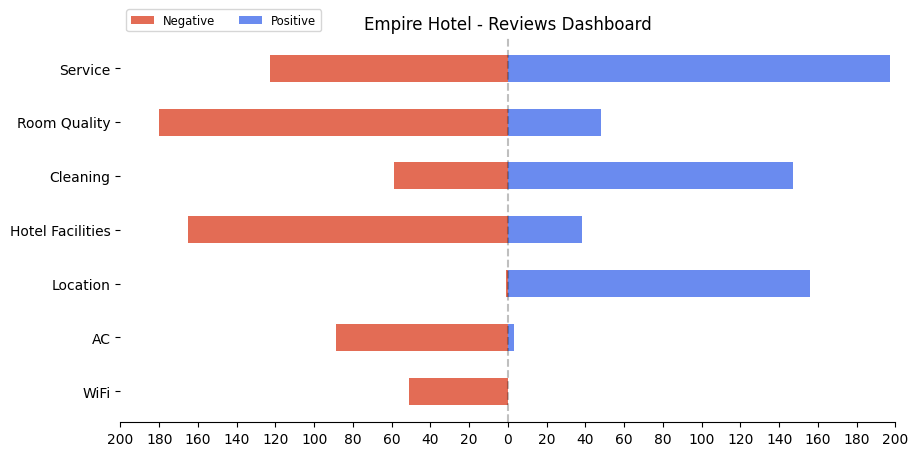

In [19]:
fig, ax = plot_dashboard(scores, category_names)
plt.show()